# Exercise X02.1
The viscous [Burgers equation](https://en.wikipedia.org/wiki/Burgers%27_equation) is given in advective form as follows:

$$
{\displaystyle {\frac {\partial u}{\partial t}}+u{\frac {\partial u}{\partial x}}=\nu {\frac {\partial ^{2}u}{\partial x^{2}}}}\nonumber
$$

A conservation variation is considered as per the exercise description (notice that wiki presents the Advective version and only has the conservative form as inviscid), here the vicid conservatine form is considered:

$${\displaystyle {\frac{\partial u}{\partial t}}+{\frac {1}{2}}{\frac{\partial (u^{2})}{\partial x}}=\nu {\frac {\partial ^{2}u}{\partial x^{2}}}}$$

To solve this non-linear PDE the Fourier transform is used to transform the problem into an ODE. This approach utilizes the relation between a function and its derivative in the Fourier domain ($\mathcal{F}$).

$$\mathcal{F}(df/dx) = i\omega\mathcal{F}(f) \Rightarrow \mathcal{F}(d^2f/dx^2) = -\omega^2\mathcal{F}(f)$$

For further details see the book chapter 2 (section on solving the Burgers equation with Fourier)

In [1]:
import numpy as np

def initial_cond(x0):
    return -np.sin(np.pi*x0)

nu = .01/np.pi # nu is epsilon in the exercise description 

In [2]:
from scipy.integrate import odeint
dx = .001
dt = 0.01

def setup_problem(dt, dx):
    x = np.arange(-1, 1, dx) # Define x domain
    u0 = initial_cond(x)
    kappa = 2*np.pi*np.fft.fftfreq(len(x), d=dx) # For the discrete Fourier transform the frequency is termed kappa not omega (2 * pi is to transform from Hz to rad/s)
    t = np.arange(0, 1, dt)
    return x, u0, kappa, t

x, u0, kappa, t = setup_problem(dt, dx)

def rhsBurgers(u,t,kappa,nu):
    uhat = np.fft.fft(u)
    d_uhat = (1j)*kappa*uhat
    dd_uhat = -np.power(kappa,2)*uhat
    d_u = np.fft.ifft(d_uhat)
    dd_u = np.fft.ifft(dd_uhat)
    du_dt = -u * d_u + nu*dd_u
    return du_dt.real

# Simulate PDE in spatial domain
u = odeint(rhsBurgers, u0, t, args=(kappa,nu))

Plotting the solution as a waterfall plot

C:\Users\nrosi\AppData\Local\Temp\ipykernel_3604\1616666174.py:6: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


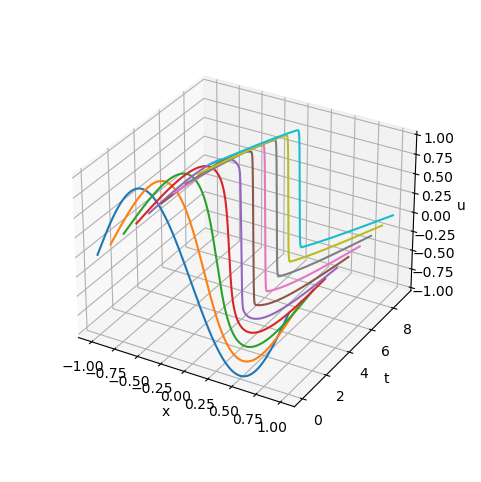

In [3]:
import matplotlib.pyplot as plt

# Waterfall plot
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.dist = 12

u_plot = u[0:-1:10,:]
for j in range(u_plot.shape[0]):
    ys = j*np.ones(u_plot.shape[1])
    ax.plot(x,ys,u_plot[j,:])
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.show();

Furthermore the gradient at the specified point is calculated ($t= 1.6037/\pi$ and $x = 0$). Different levels of discretisation are considered for the calculation of the gradient.

In [4]:
from tqdm import tqdm
from itertools import product
import time
import pandas as pd


def derivative(u, kappa):
    uhat = np.fft.fft(u)
    d_uhat = (1j)*kappa*uhat
    d_u = np.fft.ifft(d_uhat)
    return d_u.real


# dts = np.logspace(-4, -2, 3)
dts = np.linspace(.001, .01, 2)
dxs = np.linspace(.0005, .001, 3)

df = pd.DataFrame(columns=['dt', 'dx',  't_est*pi' ,'du_x', 'timing'])
for dt, dx in tqdm(product(dts, dxs)):
    x, u0, kappa, t = setup_problem(dt, dx)
    timing_start = time.time()
    u = odeint(rhsBurgers, u0, t, args=(kappa,nu))
    timing = time.time() - timing_start

    idx_t = np.argmin(np.abs(t-1.6037/np.pi))
    t_est = t[idx_t]*np.pi
    u_interest = u[idx_t, :]
    du = derivative(u_interest, kappa)
    # du = np.diff(u_interest)/dx
    df.loc[len(df)] = [dt, dx, t_est, du[np.ceil(len(du)/2).astype(int)], timing]
df

0it [00:00, ?it/s]

0it [00:29, ?it/s]

KeyboardInterrupt: 

As can be seen from the results they do not exactly refelct the target but come quite close. This coudl perhaps be improved with a finer discretisation in time as well as in space. However this is deemed to be more work than it is worth.